In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.model_selection import FeatureImportances
from pprint import pprint
import pandas as pd
from pyspark.ml.feature import VectorAssembler
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
def mean(a_list):
    return sum(a_list)/len(a_list)

spark = SparkSession.builder.appName("dataMining").getOrCreate()
heart = spark.read.csv("prepared_heart_data.csv", header=True, inferSchema=True)
train = heart.filter(heart.partition == "train").drop("partition")
test = heart.filter(heart.partition == "test").drop("partition")

print((heart.count(), len(heart.columns)))

feature_columns = [col_name for col_name in train.columns if col_name != "target"]
target_column = "target"

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_assembled = assembler.transform(train)
test_assembled = assembler.transform(test)

23/10/12 21:06:37 WARN Utils: Your hostname, Stephens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.8 instead (on interface en0)
23/10/12 21:06:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 21:06:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


(447, 15)


In [7]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

def accuracy_metrics(predictions):
    labels_and_predictions = predictions.select("target", "prediction")

    for column in labels_and_predictions.columns:
        labels_and_predictions = labels_and_predictions.withColumn(column, labels_and_predictions[column].cast('float'))

    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    # Compute and display classification metrics
    accuracy = metrics.accuracy
    # I am extremely perplexed as to why, but the recall and precision values are swapped around by pyspark????
    # I did the manual calculations, and TP/(FP+TP) should be precision, but is pysparks "recall"
    # And also TP/(TP+FN) should be recall, but is pysparks "precision"
    recall = metrics.precision(label=1.0)
    precision = metrics.recall(label=1.0)
    auc = BinaryClassificationEvaluator(labelCol="target").evaluate(predictions)

    print("Test accuracy:", round(accuracy, 3))
    print("Recall score:", round(recall, 3))
    print("Precision score:", round(precision, 3))
    print("AUC score:", round(auc, 3))

    # Create a confusion matrix
    mat = metrics.confusionMatrix().toArray().transpose()

    # Display the confusion matrix using Seaborn
    sns.heatmap(mat, square=True, annot=True, fmt='.0f', cbar=False, xticklabels=True, yticklabels=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def for_and_fdr(predictions, model_name = None):
    labels_and_predictions = predictions.select("target", "prediction")

    for column in labels_and_predictions.columns:
        labels_and_predictions = labels_and_predictions.withColumn(column, labels_and_predictions[column].cast('float'))

    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    mat = metrics.confusionMatrix().toArray().transpose()
    f_o_r = mat[1][0]/(mat[0][0]+mat[1][0])
    f_d_r = mat[0][1]/(mat[0][1]+mat[1][1])
    if model_name is not None:
        print(f"{model_name} Model:")
    print(f"False Omission Rate: {f_o_r:.4f}")
    print(f"False Discovery Rate: {f_d_r:.4f}")


def print_tree(tree):
    print("Decision Tree Structure (Text Representation):")
    string_tree = str(tree.toDebugString)
    string_tree = string_tree[string_tree.find(", depth")+2:]
    for i in range(len(feature_columns)-1,-1,-1):
        string_tree = string_tree.replace(f"feature {i}", feature_columns[i])
    print(string_tree)


sns.set_palette('Set1')

In [8]:
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel, DecisionTreeClassificationModel, GBTClassificationModel

logistic = LogisticRegressionModel.load("logistic_model")
decision_tree = DecisionTreeClassificationModel.load("dt_model")
rf = RandomForestClassificationModel.load("rf_model")
gbt = GBTClassificationModel.load("GBT_model")

## Pattern 1 - most variables decrease likelihood of of heart disease not increase

                           Coefficient     Value
0   thalassemia_type_reversible_defect -1.544103
1                     vessels_coloured -0.942043
2              exercise_induced_angina -0.897877
3         chest_pain_type_asymptomatic -0.860955
4                                  sex -0.622108
5                    num_major_vessels -0.583086
6           resting_blood_pressure_log -0.517404
7                        st_depression -0.245686
8               resting_blood_pressure -0.012484
9              max_heart_rate_achieved  0.010650
10                       rest_ecg_type  0.727957
11             st_slope_type_upsloping  0.929738
12    chest_pain_type_non-anginal_pain  0.972688
13                           intercept  3.888024


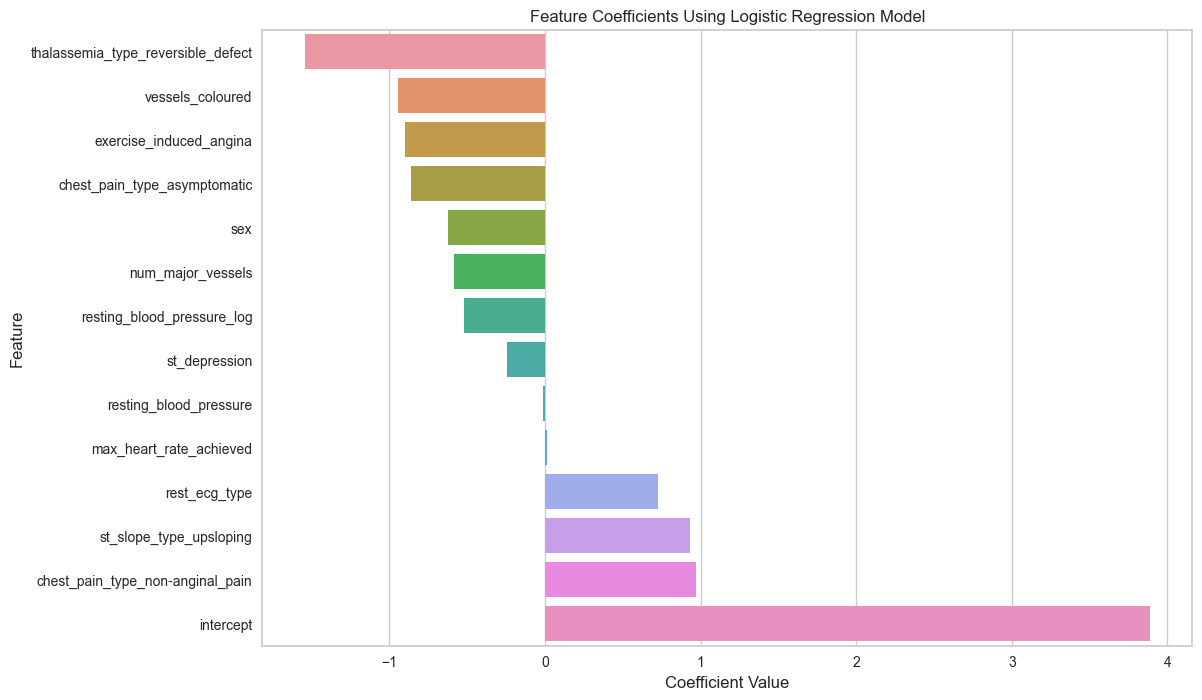

In [9]:
coefficients = logistic.coefficients.toArray()

coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", logistic.intercept)], key=lambda x: x[1])

coef_values = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Value"])
print(coef_values)

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Value", data=coef_values)
plt.title("Feature Coefficients Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

## Pattern 2 - coloured vessels, chest pain, thalassemia, & st_depression all high influence

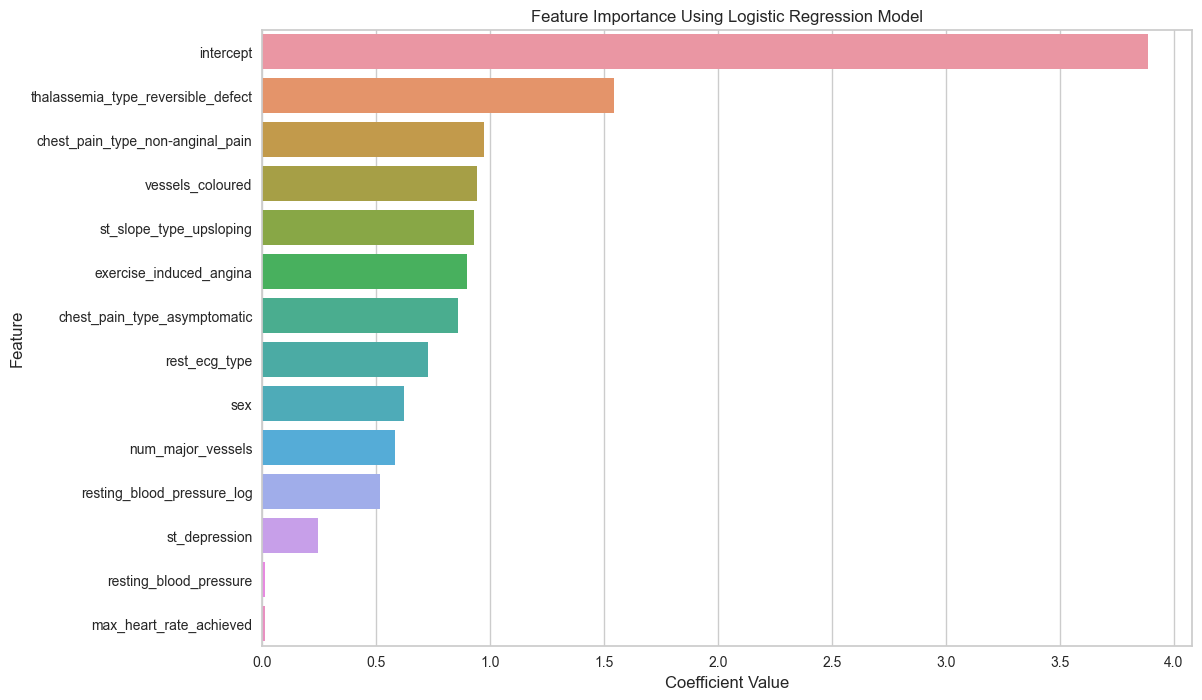

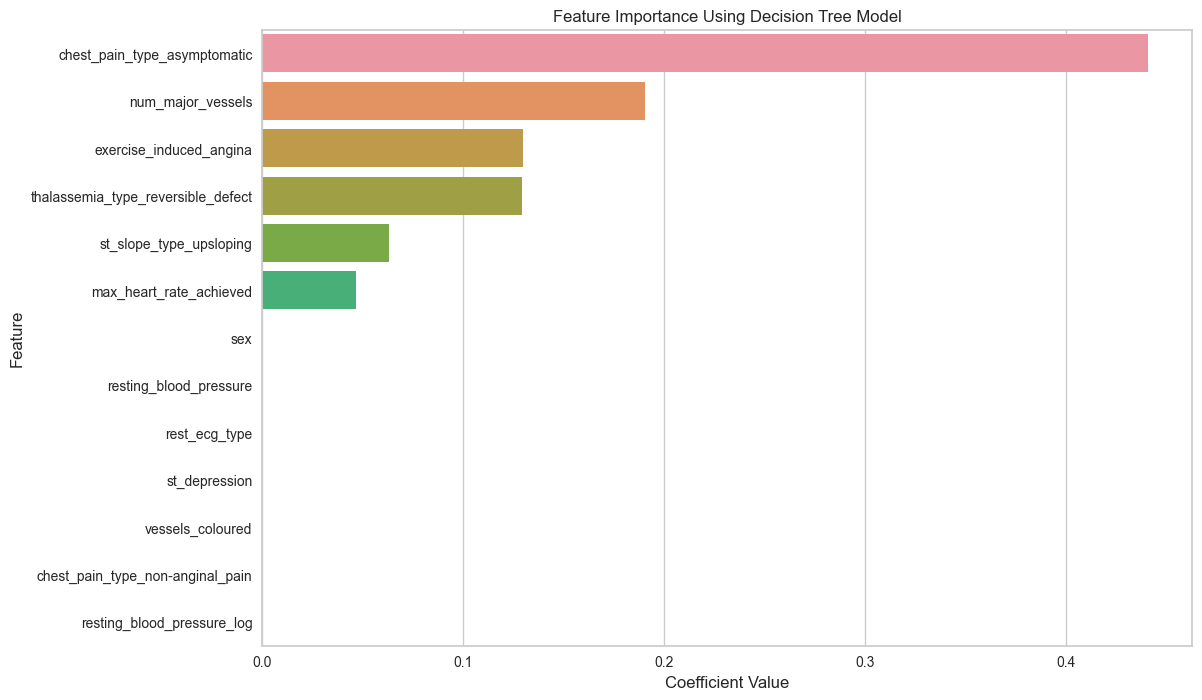

In [10]:
coef_values["Importance"] = abs(coef_values["Value"])
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=coef_values.sort_values("Importance", ascending=False))
plt.title("Feature Importance Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

coefficients = decision_tree.featureImportances.toArray()
dt_coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1], reverse=True)

feature_importance = pd.DataFrame.from_records(dt_coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Importance Using Decision Tree Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

## Pattern 3 - false omission rate higher than false discovery rate

In [11]:
rf_predictions = rf.transform(test_assembled)
logistic_predictions = logistic.transform(test_assembled)
dt_predictions = decision_tree.transform(test_assembled)
gbt_predictions = gbt.transform(test_assembled)

print()
for_and_fdr(rf_predictions, "Random Forest")
print()
for_and_fdr(gbt_predictions, "Gradient Boosted Trees")
print()
for_and_fdr(logistic_predictions, "Logistic Regression")


/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/10/12 21:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1920.9 KiB
23/10/12 21:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1933.6 KiB


Random Forest Model:
False Omission Rate: 0.2368
False Discovery Rate: 0.1778



23/10/12 21:07:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Gradient Boosted Trees Model:
False Omission Rate: 0.2368
False Discovery Rate: 0.1778

Logistic Regression Model:
False Omission Rate: 0.2500
False Discovery Rate: 0.2128


## 8.2 Visualising Patterns

                           Coefficient     Value
0   thalassemia_type_reversible_defect -1.544103
1                     vessels_coloured -0.942043
2              exercise_induced_angina -0.897877
3         chest_pain_type_asymptomatic -0.860955
4                                  sex -0.622108
5                    num_major_vessels -0.583086
6           resting_blood_pressure_log -0.517404
7                        st_depression -0.245686
8               resting_blood_pressure -0.012484
9              max_heart_rate_achieved  0.010650
10                       rest_ecg_type  0.727957
11             st_slope_type_upsloping  0.929738
12    chest_pain_type_non-anginal_pain  0.972688
13                           intercept  3.888024


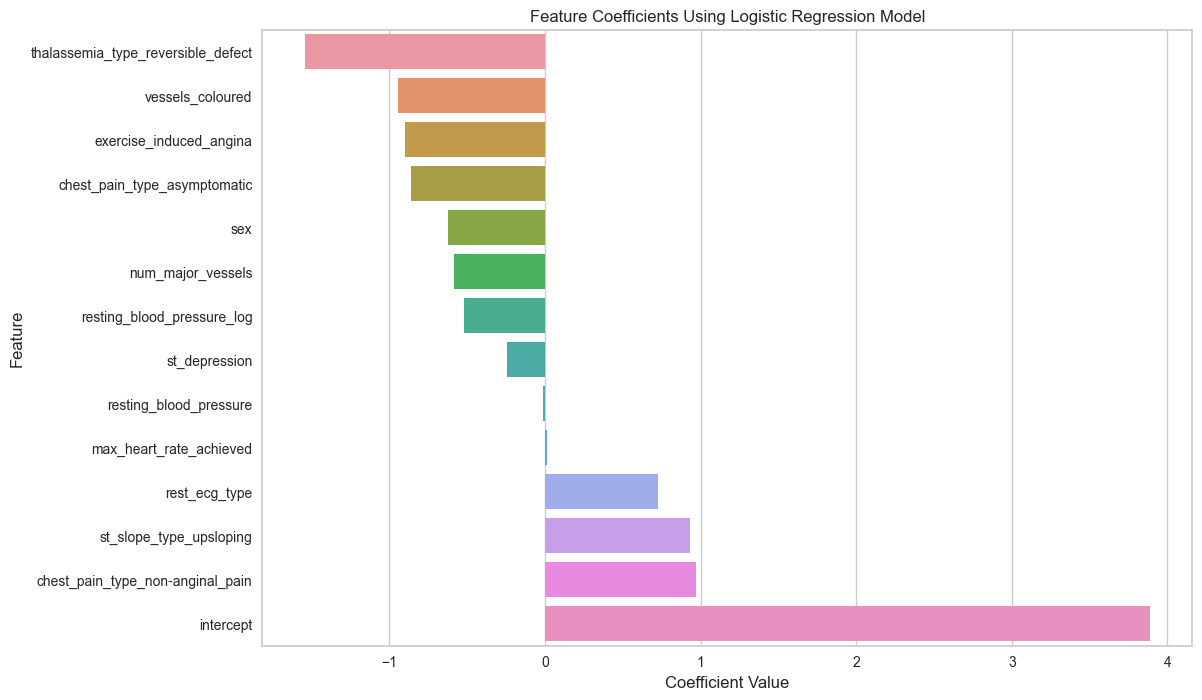

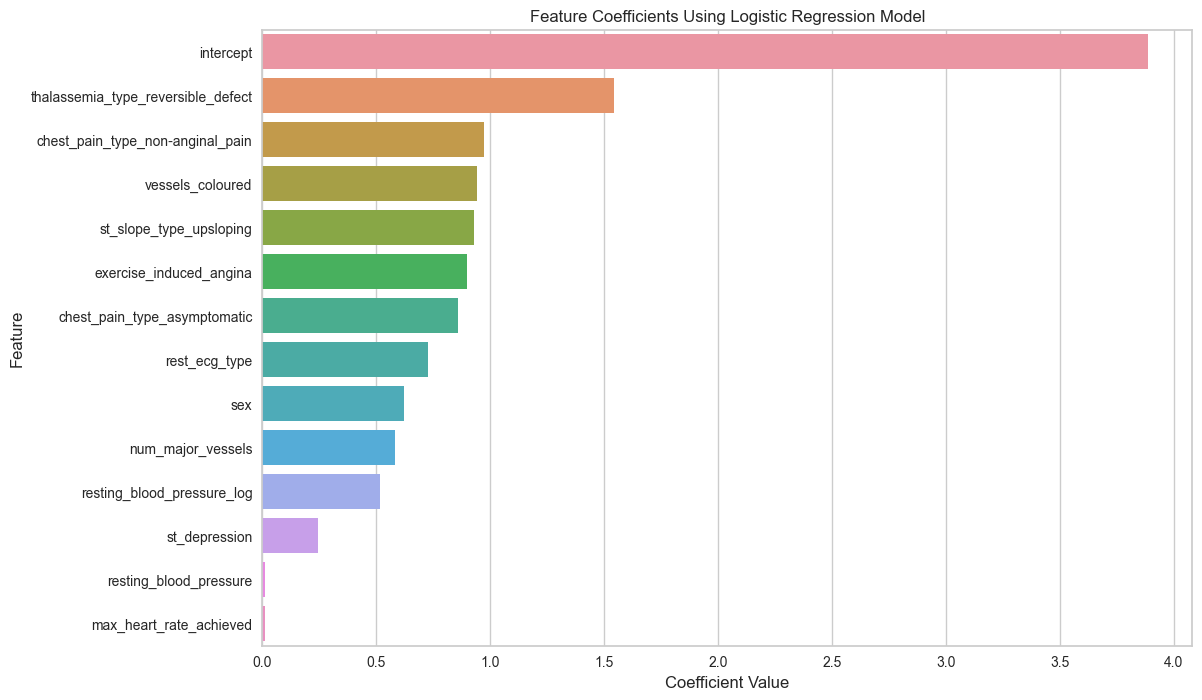

In [12]:
coefficients = logistic.coefficients.toArray()

coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", logistic.intercept)], key=lambda x: x[1])

coef_values = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Value"])
print(coef_values)
coef_values["Importance"] = abs(coef_values["Value"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Value", data=coef_values)
plt.title("Feature Coefficients Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=coef_values.sort_values("Importance", ascending=False))
plt.title("Feature Coefficients Using Logistic Regression Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

23/10/12 16:08:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


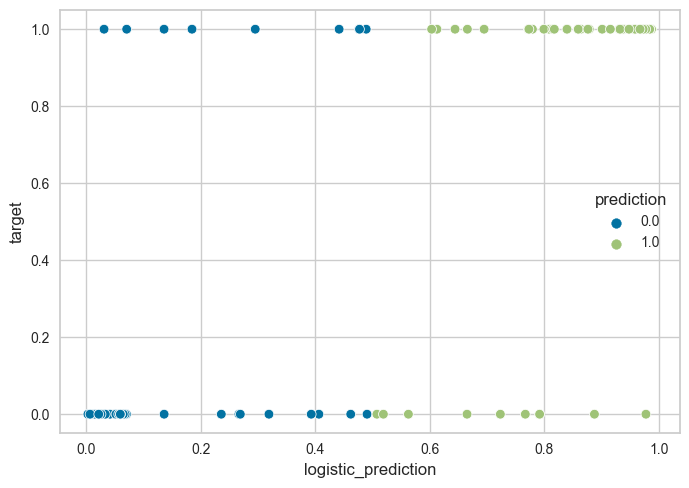

In [10]:
logistic_test_results = logistic_predictions.toPandas()
logistic_test_results['logistic_prediction'] = logistic_test_results["probability"].apply(lambda x: x[1])
sns.scatterplot(logistic_test_results, x='logistic_prediction', y='target', hue='prediction')
plt.show()

Decision Tree Structure (Text Representation):
depth=4, numNodes=17, numClasses=2, numFeatures=13
  If (chest_pain_type_asymptomatic <= 0.5)
   If (thalassemia_type_reversible_defect <= 0.5)
    If (num_major_vessels <= 1.5)
     Predict: 1.0
    Else (num_major_vessels > 1.5)
     If (max_heart_rate_achieved <= 152.5)
      Predict: 0.0
     Else (max_heart_rate_achieved > 152.5)
      Predict: 1.0
   Else (thalassemia_type_reversible_defect > 0.5)
    If (st_slope_type_upsloping <= 0.5)
     Predict: 0.0
    Else (st_slope_type_upsloping > 0.5)
     Predict: 1.0
  Else (chest_pain_type_asymptomatic > 0.5)
   If (num_major_vessels <= 0.5)
    If (exercise_induced_angina <= 0.5)
     If (thalassemia_type_reversible_defect <= 0.5)
      Predict: 1.0
     Else (thalassemia_type_reversible_defect > 0.5)
      Predict: 0.0
    Else (exercise_induced_angina > 0.5)
     Predict: 0.0
   Else (num_major_vessels > 0.5)
    Predict: 0.0



/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.771
Recall score: 0.761
Precision score: 0.814
AUC score: 0.809


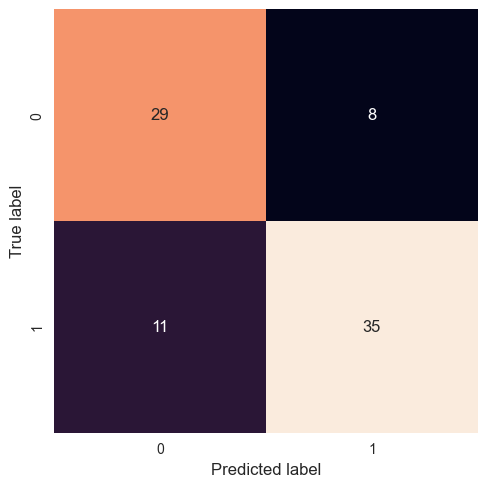

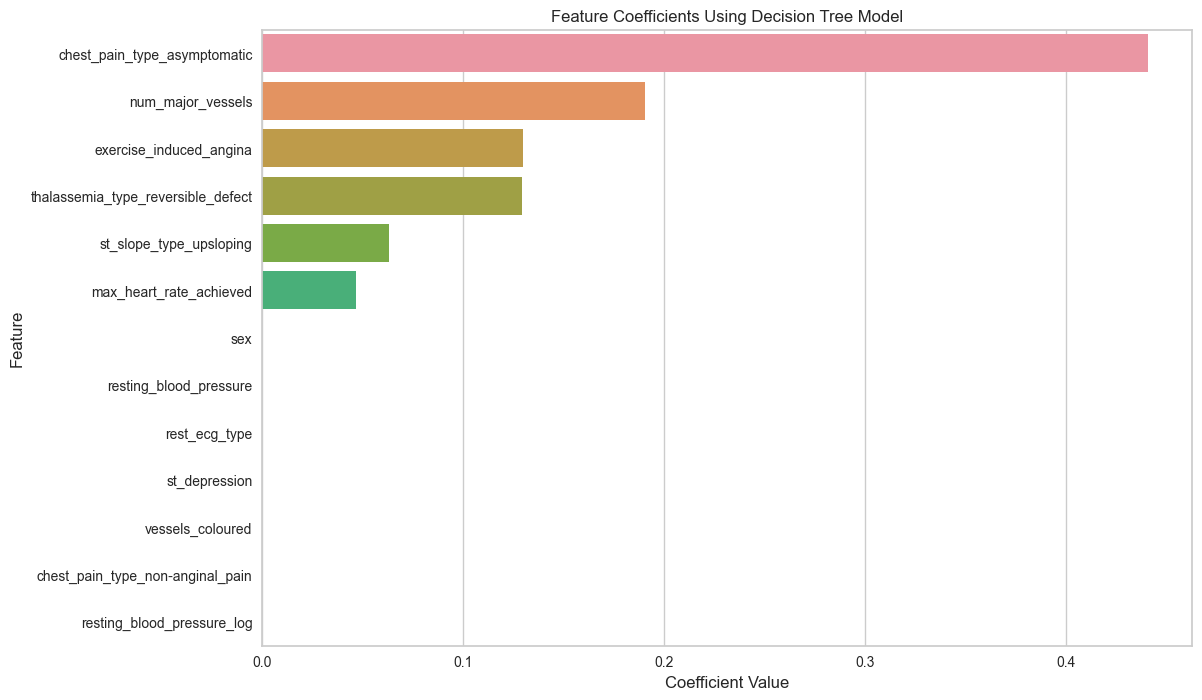

In [13]:
print_tree(decision_tree)

accuracy_metrics(dt_predictions)

coefficients = decision_tree.featureImportances.toArray()
coef_scores = sorted(list(zip(feature_columns, coefficients)), key=lambda x: x[1], reverse=True)

feature_importance = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Importance"])

# Create a barplot to visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y="Coefficient", x="Importance", data=feature_importance)
plt.title("Feature Coefficients Using Decision Tree Model")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

## Visualise Objective 2

In [14]:
from sklearn.metrics import roc_curve, RocCurveDisplay

def plot_roc_curve(predictions):
    y_real = predictions.select("target").toPandas()
    probs = predictions.select("probability").toPandas()
    y_pred = probs["probability"].apply(lambda x: x[1])
    #print(y_pred)
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
    plt.show()

/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/10/12 16:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1920.9 KiB
23/10/12 16:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1933.6 KiB
23/10/12 16:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1930.4 KiB


Test accuracy: 0.795
Recall score: 0.804
Precision score: 0.822
AUC score: 0.88


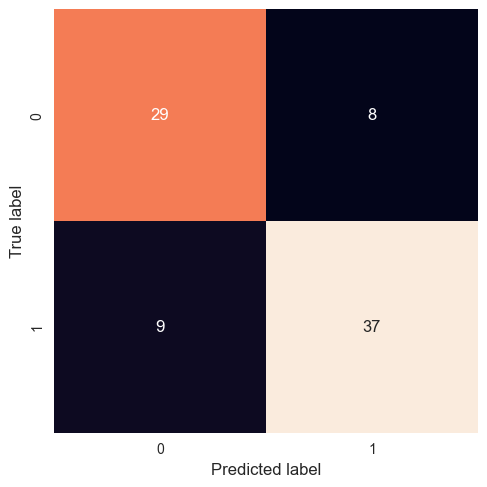

23/10/12 16:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1917.5 KiB


<Figure size 800x550 with 0 Axes>

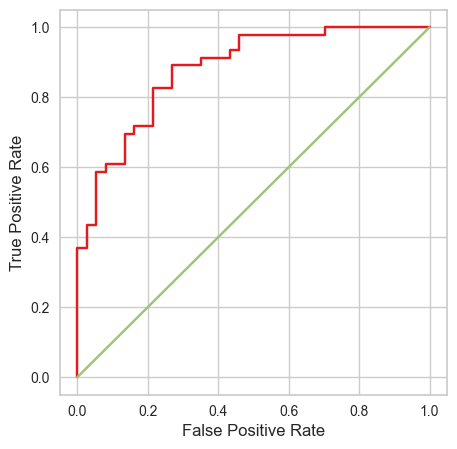

In [14]:
accuracy_metrics(rf_predictions)
plt.clf()
plot_roc_curve(rf_predictions)

/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.795
Recall score: 0.804
Precision score: 0.822
AUC score: 0.86


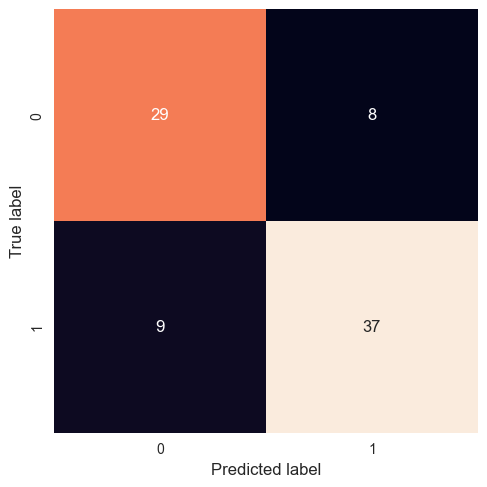

23/10/12 21:08:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


<Figure size 800x550 with 0 Axes>

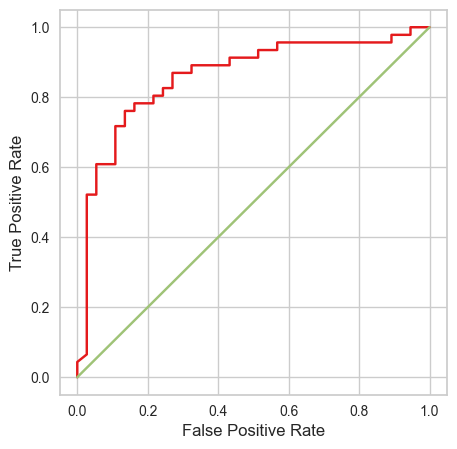

In [15]:
accuracy_metrics(gbt_predictions)
plt.clf()
plot_roc_curve(gbt_predictions)

/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.771
Recall score: 0.804
Precision score: 0.787
AUC score: 0.867


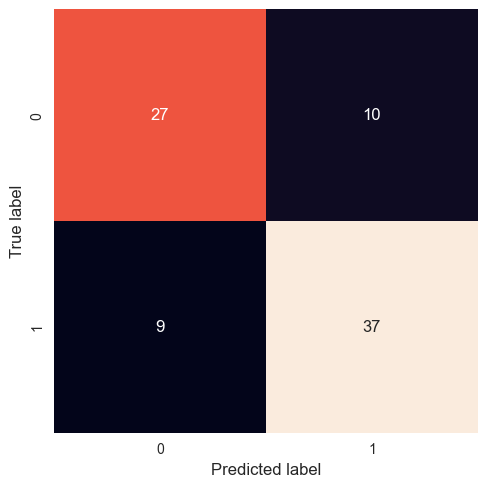

<Figure size 800x550 with 0 Axes>

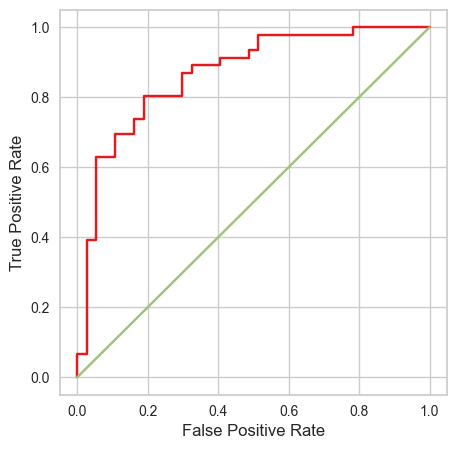

In [16]:
accuracy_metrics(logistic_predictions)
plt.clf()
plot_roc_curve(logistic_predictions)

## 8.4

In [17]:
from math import exp

coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", logistic.intercept)], key=lambda x: x[1])

coefficients = [exp(coef) for coef in logistic.coefficients.toArray()]


coef_scores = sorted(list(zip(feature_columns, coefficients)) + [("intercept", exp(logistic.intercept))], key=lambda x: x[1])

coef_values = pd.DataFrame.from_records(coef_scores, columns = ["Coefficient", "Value"])
print(coef_values)

                           Coefficient      Value
0   thalassemia_type_reversible_defect   0.213503
1                     vessels_coloured   0.389831
2              exercise_induced_angina   0.407434
3         chest_pain_type_asymptomatic   0.422758
4                                  sex   0.536812
5                    num_major_vessels   0.558173
6           resting_blood_pressure_log   0.596066
7                        st_depression   0.782168
8               resting_blood_pressure   0.987594
9              max_heart_rate_achieved   1.010707
10                       rest_ecg_type   2.070845
11             st_slope_type_upsloping   2.533845
12    chest_pain_type_non-anginal_pain   2.645045
13                           intercept  48.814311


## 8.5

### Voting classifier

23/10/12 21:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1917.6 KiB
23/10/12 21:08:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 21:08:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 21:08:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 21:08:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 21:08:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/12 21:08:36 WARN WindowExec: No Partition Defined for Window operation! Moving a

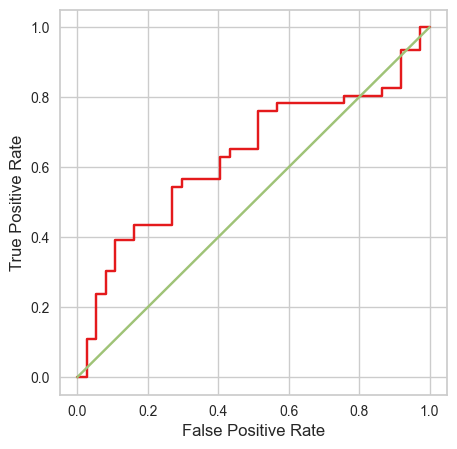

In [18]:
from pyspark.sql.functions import col, lit, when
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

voting_rf_predictions = rf_predictions.withColumnRenamed("probability", "rf_probability").select("rf_probability")
voting_logistic_predictions = logistic_predictions.withColumnRenamed("probability", "logistic_probability").select("logistic_probability")
voting_gbt_predictions = gbt_predictions.withColumnRenamed("probability", "gbt_probability").select("gbt_probability")
target = rf_predictions.select("target")
target = target.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))

voting_rf_predictions = spark.createDataFrame(voting_rf_predictions.toPandas()["rf_probability"].apply(lambda x: x[1]).reset_index())
voting_logistic_predictions = spark.createDataFrame(voting_logistic_predictions.toPandas()["logistic_probability"].apply(lambda x: x[1]).reset_index())
voting_gbt_predictions = spark.createDataFrame(voting_gbt_predictions.toPandas()["gbt_probability"].apply(lambda x: x[1]).reset_index())

voting_predictions = voting_rf_predictions.join(voting_logistic_predictions, on=["index"]).join(voting_gbt_predictions, on=["index"])
voting_predictions = voting_predictions.select(((col("rf_probability") + col("logistic_probability") + col("gbt_probability")) / lit(3)).alias("probability"))
voting_predictions = voting_predictions.withColumn("prediction", when(col("probability") < 0.5, 0).otherwise(1))

voting_predictions = voting_predictions.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))
target = target.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))

voting_predictions = voting_predictions.join(target, on=["index"]).drop("index")

y_real = voting_predictions.select("target").toPandas()
y_pred = voting_predictions.select("probability").toPandas()

fpr, tpr, _ = roc_curve(y_real, y_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(5,5)
plt.plot([0, 1], [0, 1], color = 'g')
plt.show()


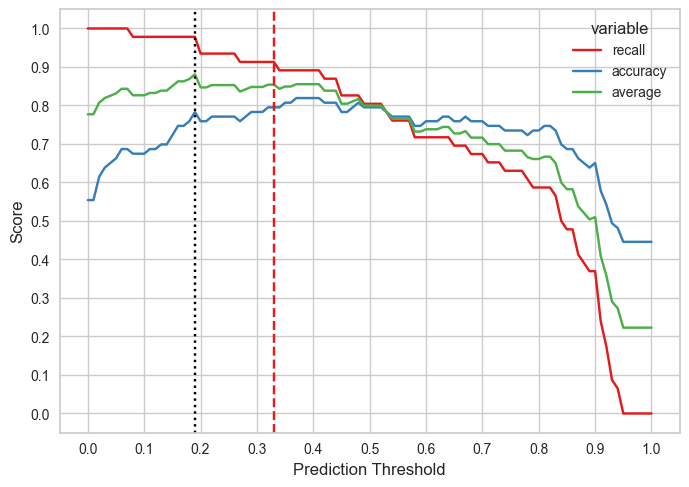

In [22]:
from sklearn.metrics import recall_score, accuracy_score

def prob_predict(threshold):
    y_pred = voting_rf_predictions.withColumn("prediction", when(col("rf_probability") < threshold, 0).otherwise(1))
    return y_pred.select("prediction").toPandas().astype(int)

test_y = test.select("target").toPandas()

thresholds = list(np.arange(0,1.01,0.01))
predictions = map(prob_predict, thresholds)

recall_scores = [recall_score(test_y, y_pred) for y_pred in predictions]
predictions = map(prob_predict, thresholds)
accuracy_scores = [accuracy_score(test_y, y_pred) for y_pred in predictions]
plot_data = pd.DataFrame()
plot_data['threshold'] = thresholds
plot_data['recall'] = recall_scores
plot_data['accuracy'] = accuracy_scores
plot_data['average'] = [(recall_scores[i]+accuracy_scores[i])/2 for i in range(len(accuracy_scores))]
sns.lineplot(data=pd.melt(plot_data, ['threshold']), x='threshold', y='value', hue='variable')
plt.axvline(x=0.33, linestyle="--")
plt.axvline(x=0.19, linestyle=":", color="black")
plt.xlabel("Prediction Threshold")
plt.ylabel("Score")
plt.locator_params(axis='both', nbins=11)
plt.show()

### Accuracy Metrics

/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.783
Recall score: 0.978
Precision score: 0.726


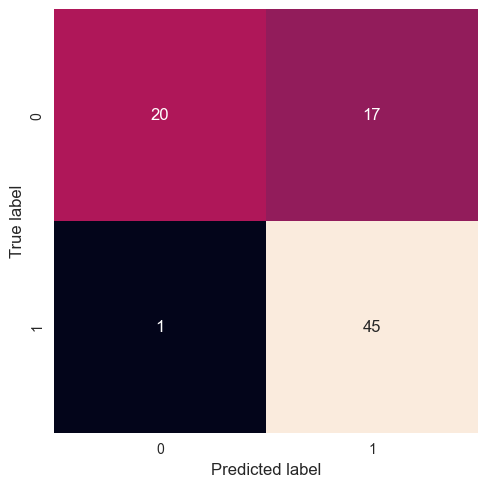

In [26]:
def threshold_accuracy_metrics(predictions):
    labels_and_predictions = predictions.select("target", "prediction")

    for column in labels_and_predictions.columns:
        labels_and_predictions = labels_and_predictions.withColumn(column, labels_and_predictions[column].cast('float'))

    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    # Compute and display classification metrics
    accuracy = metrics.accuracy
    # I am extremely perplexed as to why, but the recall and precision values are swapped around by pyspark????
    # I did the manual calculations, and TP/(FP+TP) should be precision, but is pysparks "recall"
    # And also TP/(TP+FN) should be recall, but is pysparks "precision"
    recall = metrics.precision(label=1.0)
    precision = metrics.recall(label=1.0)

    print("Test accuracy:", round(accuracy, 3))
    print("Recall score:", round(recall, 3))
    print("Precision score:", round(precision, 3))

    # Create a confusion matrix
    mat = metrics.confusionMatrix().toArray().transpose()

    # Display the confusion matrix using Seaborn
    sns.heatmap(mat, square=True, annot=True, fmt='.0f', cbar=False, xticklabels=True, yticklabels=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

optimal_results = pd.DataFrame()
optimal_results["target"] = test_y
optimal_results["prediction"] = prob_predict(0.19)
predictions = spark.createDataFrame(optimal_results.reset_index()).drop("index")


threshold_accuracy_metrics(predictions)

### Create threshold object

23/10/12 21:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1935.8 KiB
/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.783
Recall score: 0.978
Precision score: 0.726
AUC score: 0.88


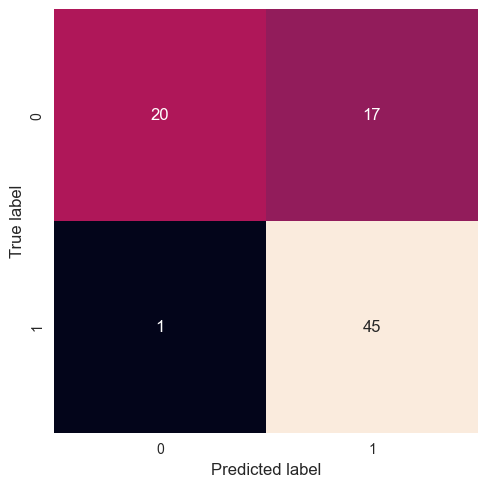

In [28]:
#create model with built in threshold compatibility
from pyspark.ml.classification import RandomForestClassifier

class CardiovascularModel():
    def __init__(self, estimator = None, threshold=0.19):
        self.threshold=threshold
        if estimator != None:
            self.base_estimator = estimator
        else:
            self.base_estimator = RandomForestClassifier(featuresCol="features", labelCol="target", seed=722,
                                                         numTrees=400,
                                                         impurity="entropy",
                                                         featureSubsetStrategy="auto")
    
    def fit(self,x):
        self.base_estimator = self.base_estimator.fit(x)
        return self.base_estimator

    def transform(self,x):
        x = self.base_estimator.transform(x)
        new = x.toPandas()
        new["probability"] = new["probability"].apply(lambda x: x[1])
        new["prediction"] = new["probability"].apply(lambda x: 0 if x < self.threshold else 1)
        x = spark.createDataFrame(new.reset_index())
        return x
    
#final results
cardio_model = CardiovascularModel(estimator=rf)
cardio_results = cardio_model.transform(test_assembled)
accuracy_metrics(cardio_results)

23/10/12 21:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1511.7 KiB
23/10/12 21:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1818.6 KiB
/Users/stephen/Library/Python/3.9/lib/python/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Test accuracy: 0.795
Recall score: 0.913
Precision score: 0.764
AUC score: 0.88


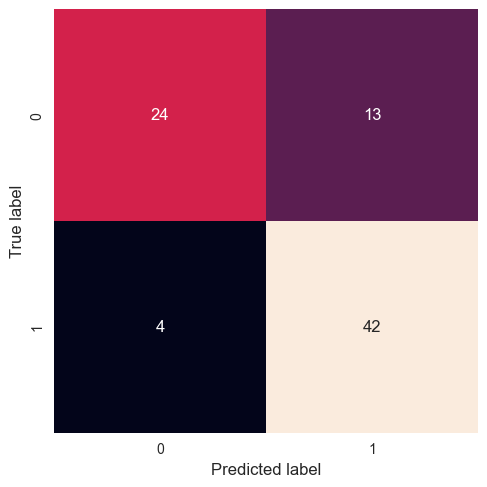

In [29]:
new_cardio_model = CardiovascularModel(threshold=0.33)
new_cardio_model.fit(train_assembled)
new_cardio_results = new_cardio_model.transform(test_assembled)

accuracy_metrics(new_cardio_results)